# Answering Business Questions using SQL

Answering some hypothetical business questions for an organization in the music industry, using the [chinook](https://github.com/lerocha/chinook-database) database, which contains records for a fictional online music store.

## Setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

# Creating a function that takes a SQL query as an argument
# and returns a pandas dataframe of that query. 

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# Creating a function that takes a SQL command as an argument 
# and executes it using the sqlite module

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

# Creating a function that calls the run_query() function to return a 
# list of all tables and views in the database

def show_tables():
    st = "SELECT name, type FROM sqlite_master WHERE type IN (\"table\",\"view\");"
    return run_query(st)
    
show_tables()


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Tracks Sold per Genre

A record label has a few artist they would like distribute in the US:

Artist Name | Genre
--- | --- 
Regal|Hip-Hop
Red Tone|Punk
Meteor and the Girls|Pop
Slim Jim Bites|Blues

An analysis will be performed to see which genres are popular in America, so the label can determine which artists to promote.  

    genre_name  tracks_sold  Percent_of_total_tracks_sold
0        Metal          619                         58.90
1     R&B/Soul          159                         15.13
2        Blues          124                         11.80
3         Jazz          121                         11.51
4          Pop           63                          5.99
5  Hip Hop/Rap           33                          3.14
6  Heavy Metal            8                          0.76
7     TV Shows            2                          0.19


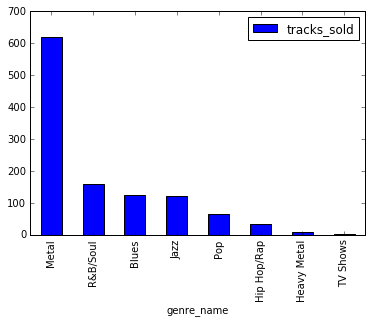

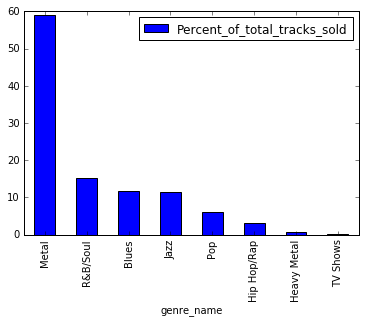

In [2]:
# Creating a plot of each genre, with the number of tracks sold in absolute 
# numbers and in percentages

genre_query = """

WITH track_numbers AS (
  SELECT g.name genre_name, SUM(il.quantity) tracks_sold
  FROM track t
  INNER JOIN genre g ON t.genre_id = g.genre_id
  INNER JOIN invoice_line il ON il.track_id = t.track_id
  INNER JOIN invoice i on il.invoice_id = i.invoice_id
  GROUP BY g.name
  HAVING i.billing_country = "USA"
  ),
  all_tracks AS (
  SELECT SUM(quantity) total_tracks
  FROM invoice_line il
  INNER JOIN invoice i ON i.invoice_id = il.invoice_id
  WHERE i.billing_country = "USA"
  )
  
  
  
  SELECT tn.*, ROUND((CAST(tn.tracks_sold as Float)/CAST(at.total_tracks
                     as float)*100), 2) Percent_of_total_tracks_sold
  FROM track_numbers tn, all_tracks at
  ORDER BY tn.tracks_sold DESC;

"""

genre_sales_usa = run_query(genre_query)
print(genre_sales_usa)
genre_sales_usa.plot.bar(x="genre_name", y="tracks_sold")
genre_sales_usa.plot.bar(x="genre_name", y="Percent_of_total_tracks_sold")



Based on the results, it would be best to promote Slim Jim Bites, Meteor and the Girls, and Regal, in that order.

## Total Sales per Sales Support Agent

Below is a list of the top selling agents in the organization, as well as analysis on determining factors that attribute to their success.

     sales_agent     supervisor            birthdate            hire_date  \
0   Jane Peacock  Nancy Edwards  1973-08-29 00:00:00  2017-04-01 00:00:00   
1  Margaret Park  Nancy Edwards  1947-09-19 00:00:00  2017-05-03 00:00:00   
2  Steve Johnson  Nancy Edwards  1965-03-03 00:00:00  2017-10-17 00:00:00   

   total_sales  
0      1731.51  
1      1584.00  
2      1393.92  


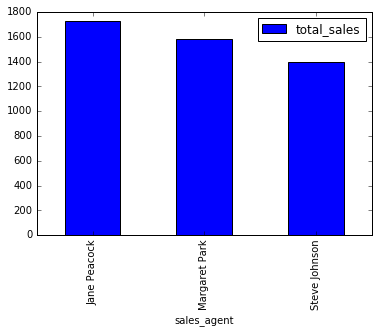

In [3]:
# Writing a query that finds the total dollar amount of sales assigned 
# to each sales support agent within the company, along with their date
# of birth, supervisor, and date they started with the company

sales_per_agent_query = """

SELECT 
    e1.first_name || " " || e1.last_name sales_agent,
    e2.first_name || " " || e2.last_name supervisor,
    e1.birthdate,
    e1.hire_date,
    ROUND(SUM(i.total),2) total_sales
    
FROM employee e1
INNER JOIN employee e2 ON e1.reports_to = e2.employee_id
INNER JOIN customer c ON e1.employee_id = c.support_rep_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY e1.employee_id
HAVING e1.title = "Sales Support Agent"
ORDER BY total_sales DESC

"""

sales_per_agent = run_query(sales_per_agent_query)
print(sales_per_agent)
sales_per_agent.plot.bar(x="sales_agent",y="total_sales")

Of the employee attributes that were examined, **hire_date** is the one that stands out as a potential explanation for the sales numbers.  It appears that sales numbers correlate positively with the number of days an agent has been working with the company.  This could mean that a higher sales total may not be attributed to performance, but to how long the person has been with the company.  

     sales_agent            hire_date  total_sales  sales_per_workday
0   Jane Peacock  2017-04-01 00:00:00      1731.51           3.587395
1  Margaret Park  2017-05-03 00:00:00      1584.00           3.514805
2  Steve Johnson  2017-10-17 00:00:00      1393.92           4.913964


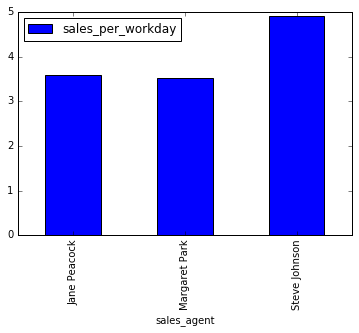

In [4]:
sales_per_agent_query2 = """

SELECT 
    e1.first_name || " " || e1.last_name sales_agent,

    e1.hire_date,
    ROUND(SUM(i.total),2) total_sales,
    ROUND(SUM(i.total),2)/(julianday('now') - julianday(e1.hire_date)) sales_per_workday
FROM employee e1
INNER JOIN customer c ON e1.employee_id = c.support_rep_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY e1.employee_id
HAVING e1.title = "Sales Support Agent"
ORDER BY total_sales DESC
"""

sales_per_agent2 = run_query(sales_per_agent_query2)
print(sales_per_agent2)
sales_per_agent2.plot.bar(x="sales_agent",y="sales_per_workday")

I added a column for sales amount per days worked for the company, and it looks like there's an inverse relationship between that and how long someone has worked for the company.  The extra column doesn't account for days off, so it isn't 100% accurate.

## Sales Data by Country

The store is interested in analyzing sales data countries where they have had customers, in order to reveal any interesting trends.

In [5]:
# Writing a query that collates data on purchases from different countries, 
# which includes columns for total number of customers, total value of sales
# average value of sales per customer, and average order value.  Countries
# with just one customer are lumped together into an "Other" group, and
# that group is listed last.


country_sales_query = """

WITH 
    total_customers AS (
        SELECT country nation, COUNT(*) num_of_customers 
        FROM customer 
        GROUP BY country
     ), 
    total_value AS(
        SELECT c.country nation, SUM(i.total) total_sales, AVG(i.total) avg_sales
        FROM invoice i 
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY nation
      ),
    multi_customer_countries AS (
        SELECT 
            tc.nation, 
            tc.num_of_customers, 
            tv.total_sales total_sales_country,
            CAST(tv.total_sales as float)/CAST(tc.num_of_customers as Float) average_value_per_customer,
            tv.avg_sales average_order_value 
        FROM total_customers tc
        INNER join total_value tv ON tv.nation = tc.nation
        WHERE tc.num_of_customers > 1
      ), 
    other_countries AS (
        SELECT 
            CASE
                WHEN tc.num_of_customers = 1 THEN "Other"
            END
            as nation,
            COUNT(*) num_of_customers,
            SUM(tv.total_sales) total_sales_country,
            CAST(SUM(tv.total_sales) AS float)/CAST(COUNT(*) as FLOAT) average_value_per_customer,
            AVG(tv.avg_sales) avg_order_value
        FROM total_customers tc
        INNER join total_value tv ON tv.nation = tc.nation
        WHERE tc.num_of_customers = 1
      ),
    final_sales as (
        SELECT * FROM multi_customer_countries
        UNION
        SELECT * FROM other_countries
      )
      
SELECT nation, num_of_customers, total_sales_country, average_order_value, average_value_per_customer
FROM (
  SELECT
      fs.*,
      CASE
          WHEN fs.nation = "Other" THEN 1
          ELSE 0
      end AS sort
  FROM final_sales fs
  )
order by sort ASC, total_sales_country DESC

"""

run_query(country_sales_query)

,nation,num_of_customers,total_sales_country,average_order_value,average_value_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.445071,72.996000


In [6]:
# Creating a dataframe without the 'Other' categoty

data1 = run_query(country_sales_query)
country_data = data1[0:9].set_index("nation", drop=False)

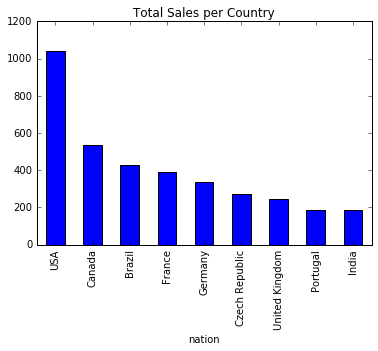

In [7]:
# Creating a pie chart for Total Sales per Country

country_data.sort_values(by='total_sales_country', ascending=False).plot.bar(y='total_sales_country', 
                      legend=False, title="Total Sales per Country")

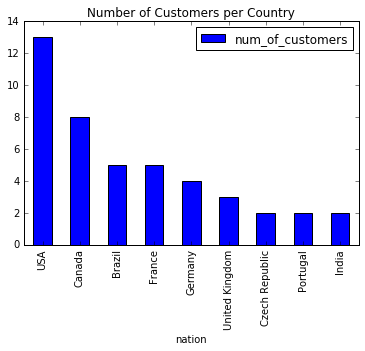

In [8]:
# Creating a bar chart for number of customers per country

country_data.sort_values(by='num_of_customers', ascending=False).plot.bar(y='num_of_customers', title="Number of Customers per Country")


The United States has the largest number of sales for any country, followed by Canada, Brazil, and France.  This makes sense, since those 4 countries make up the largest 4 providers of customers, respectively.  

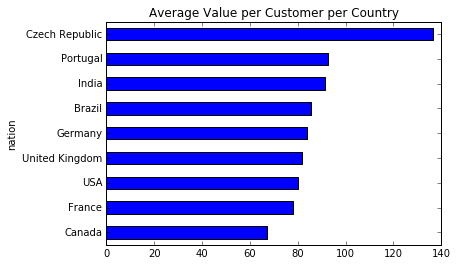

In [9]:
country_data.sort_values(by='average_value_per_customer').plot.barh(y='average_value_per_customer', legend=False, title="Average Value per Customer per Country")

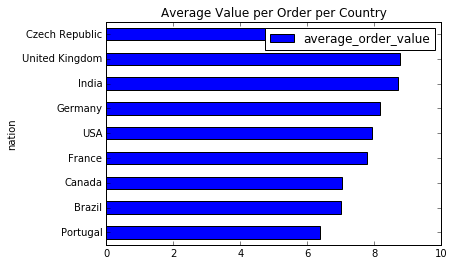

In [10]:
country_data.sort_values(by='average_order_value').plot.barh(y='average_order_value', legend=True, title="Average Value per Order per Country")

However, when examining the averages of sales per order and per customer, India and the Czech Republic lead the way.  While they have a few customers, they, on average, spent more money on music than customers from the 4 highest grossing nations.  Those may be markets to consider in the future.

## Should the store continue to sell full albums, or only sell singles?

The music store is considering a strategy to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.  In order to make this decision, it would be best to determine the percentage of purchases are individual tracks vs whole albums.

In [11]:
# Writing a query that categorizes each invoice as either an album purchase 
# or not, and calculates the number and percentage of invoices that match
# either scenario

album_query = """

WITH 
multi_track AS(
  SELECT al.album_id, COUNT(*) num_of_tracks FROM track t
  INNER JOIN album al on al.album_id = t.album_id
  GROUP BY al.album_id
  ),
full_albums AS (
  SELECT t.name track_name, al.title album_title, t.track_id, al.album_id
  FROM track t
  inner join album al ON al.album_id = t.album_id
  INNER JOIN multi_track mt on mt.album_id = al.album_id
  WHERE mt.num_of_tracks > 1
  ),
invoice_albums AS (
  SELECT t.name track_name, al.title album_title, t.track_id, il.invoice_id, al.album_id
  FROM track t
  INNER JOIN invoice_line il on il.track_id = t.track_id
  inner join album al ON al.album_id = t.album_id
  ), 
invoice_full_album_status AS (
    SELECT 
    DISTINCT ia.invoice_id invoice,
    ia.album_title album,
    CASE
      when
        (
        SELECT fa2.track_name from full_albums fa2 WHERE fa2.album_id = fa.album_id
        EXCEPT
        SELECT ia2.track_name from invoice_albums ia2 WHERE ia2.invoice_id = ia.invoice_id AND ia2.album_id = ia.album_id) IS NULL 
        AND (
        SELECT ia3.track_name from invoice_albums ia3 WHERE ia3.invoice_id = ia.invoice_id AND ia3.album_id = ia.album_id
        EXCEPT
        SELECT fa3.track_name from full_albums fa3 WHERE fa3.album_id = fa.album_id) IS NULL
        THEN 1 ELSE 0 END AS bought_full_album
    FROM full_albums fa
    INNER JOIN invoice_albums ia on ia.track_id = fa.track_id
    ORDER BY ia.invoice_id
    )
    
    
SELECT
  CASE
    When ifas.bought_full_album = 1 THEN "Yes"
    ELSE "No" END as "Users That Bought Full Album",
  CASE
    When ifas.bought_full_album = 1 THEN (SELECT COUNT(distinct ifas1.invoice) FROM invoice_full_album_status ifas1 WHERE ifas1.bought_full_album = 1)
    ELSE (SELECT COUNT(distinct ifas0.invoice) FROM invoice_full_album_status ifas0 WHERE ifas0.bought_full_album = 0) END as "Number of Invoices",
  CASE
    When ifas.bought_full_album = 1 THEN (SELECT CAST(COUNT(distinct ifas1.invoice) AS Float)/CAST((SELECT COUNT(*) FROM invoice) AS float) FROM invoice_full_album_status ifas1 WHERE ifas1.bought_full_album = 1)
    ELSE (SELECT CAST(COUNT(distinct ifas0.invoice) AS Float)/CAST((SELECT COUNT(*) FROM invoice) AS float) FROM invoice_full_album_status ifas0 WHERE ifas0.bought_full_album = 0) END as "Percentage of Invoices"
FROM invoice_full_album_status ifas
GROUP BY ifas.bought_full_album

"""

run_query(album_query)

,Users That Bought Full Album,Number of Invoices,Percentage of Invoices
0,No,500,0.814332
1,Yes,111,0.180782


It appears that only about a fifth of purchases were of full albums, so it would be a reasonable strategy to only sell singles on the site.